# Thread Detection in Woven Fabrics Using FFT

This notebook analyzes woven fabric images to detect and count threads using Fourier Transform.

**Author:** Thread Detection System  
**Method:** FFT (Fourier Transform) - Classic textile analysis approach  
**Key Features:**
- Fast analysis (~0.5 seconds)
- No parameter tuning needed
- Works great for regular weave patterns
- Detects both horizontal and vertical threads simultaneously

---

## 1. Setup & Imports

First, let's import all the libraries we need.

In [6]:
# Complete cleanup and fresh install
import sys

# Uninstall ALL opencv variants
!{sys.executable} -m pip uninstall opencv-python opencv-python-headless opencv-contrib-python -y

# Install headless version
!{sys.executable} -m pip install opencv-python-headless

print("✓ Installation complete!")
print("⚠️ IMPORTANT: Now restart the kernel!")
print("   Kernel → Restart")

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 87.2 MB/s eta 0:00:00:00:010:01m
✓ Installation complete!
⚠️ IMPORTANT: Now restart the kernel!
   Kernel → Restart


In [1]:
# After kernel restart, test imports
import sys
import cv2

print(f"✓ OpenCV version: {cv2.__version__}")
print(f"✓ OpenCV path: {cv2.__file__}")

# Check if it's the headless version
if 'headless' in cv2.__file__:
    print("✓ Using opencv-python-headless (correct!)")
else:
    print("⚠️ Not using headless version - reinstall needed")

✓ OpenCV version: 4.12.0
✓ OpenCV path: /opt/conda/lib/python3.12/site-packages/cv2/__init__.py
⚠️ Not using headless version - reinstall needed


In [2]:
# Enable inline plotting
%matplotlib inline

# Import libraries
import cv2
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set default figure size for better visibility
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")
print(f"✓ OpenCV version: {cv2.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ All libraries imported successfully!
✓ OpenCV version: 4.12.0
✓ NumPy version: 2.2.6


## 2. Load Your Fabric Image

**📝 Instructions:**
1. Upload your fabric image to Jupyter (use Upload button)
2. Change the `image_path` below to your image filename
3. Run this cell to load and display the image

✓ Successfully loaded: plain_weave_1.jpg
✓ Image size: 1300 × 865 pixels
✓ Aspect ratio: 1.50


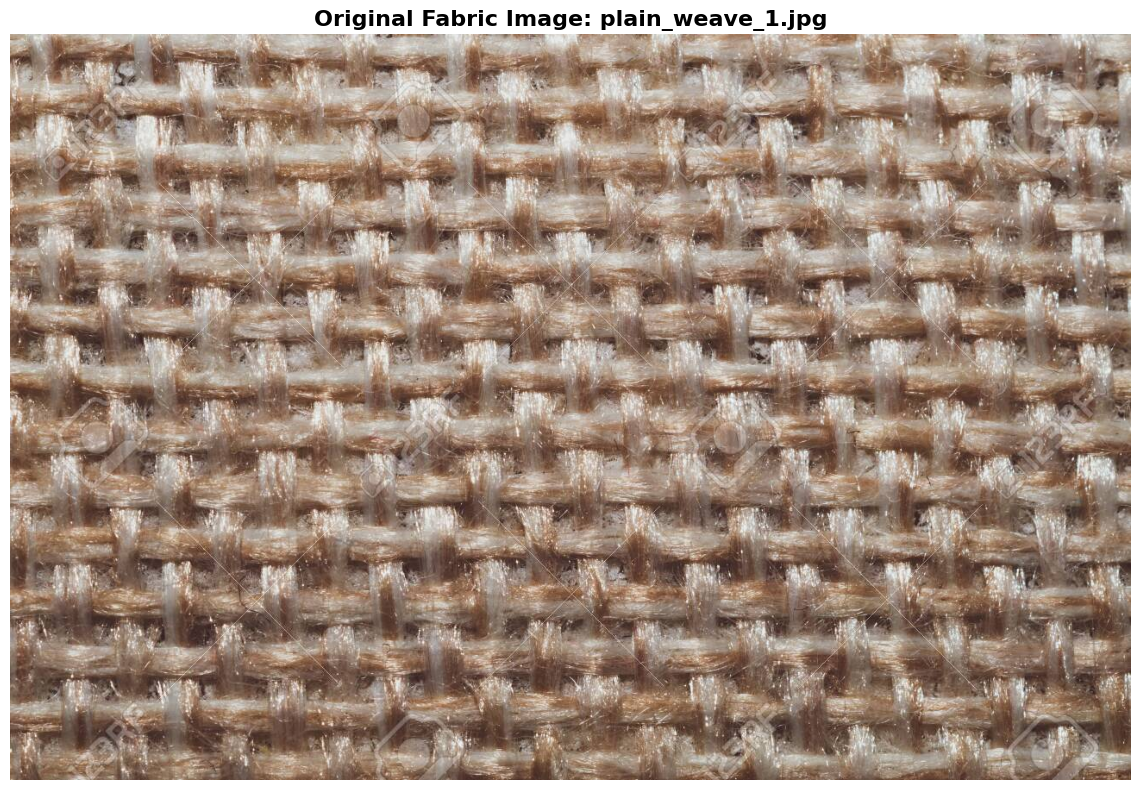

In [40]:
# ========================================
# CHANGE THIS to your image filename
# ========================================
image_path = "plain_weave_1.jpg"  # ← Change this!

# Load the image
img = cv2.imread(image_path)

if img is None:
    print(f"❌ ERROR: Could not load image '{image_path}'")
    print("   Make sure:")
    print("   1. The file is uploaded to Jupyter")
    print("   2. The filename is correct (including extension)")
    print("   3. The file is in the same directory as this notebook")
else:
    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    
    print(f"✓ Successfully loaded: {image_path}")
    print(f"✓ Image size: {width} × {height} pixels")
    print(f"✓ Aspect ratio: {width/height:.2f}")
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f'Original Fabric Image: {image_path}', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 3. Preprocess the Image

We'll enhance the image to make thread patterns more visible:
- **CLAHE**: Contrast Limited Adaptive Histogram Equalization
- **Hamming Window**: Reduces edge effects in FFT

✓ Preprocessing complete


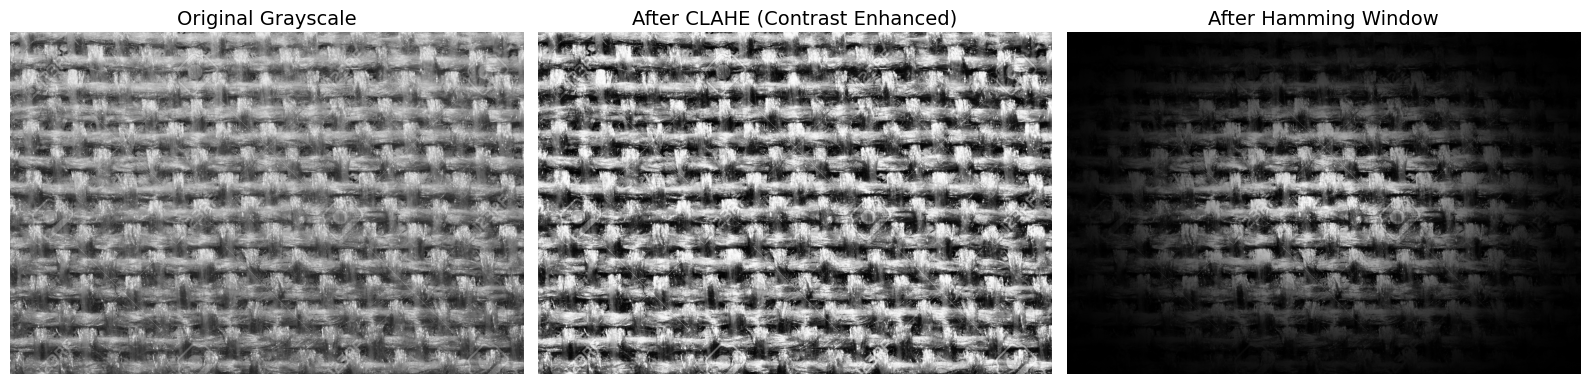

In [41]:
# Enhance contrast using CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_enhanced = clahe.apply(gray)

# Apply Hamming window to reduce edge effects
window_y = np.hamming(height)[:, np.newaxis]
window_x = np.hamming(width)[np.newaxis, :]
window = window_y @ window_x
gray_windowed = gray_enhanced * window

print("✓ Preprocessing complete")

# Visualize preprocessing steps
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Original Grayscale', fontsize=14)
axes[0].axis('off')

axes[1].imshow(gray_enhanced, cmap='gray')
axes[1].set_title('After CLAHE (Contrast Enhanced)', fontsize=14)
axes[1].axis('off')

axes[2].imshow(gray_windowed, cmap='gray')
axes[2].set_title('After Hamming Window', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Compute the FFT (Fourier Transform)

This is where the magic happens! 🎩✨

The FFT converts the spatial pattern into frequency domain:
- **Periodic patterns** (threads) → **Peaks in frequency**
- Peak position tells us thread spacing

Computing 2D FFT...
✓ FFT computation complete


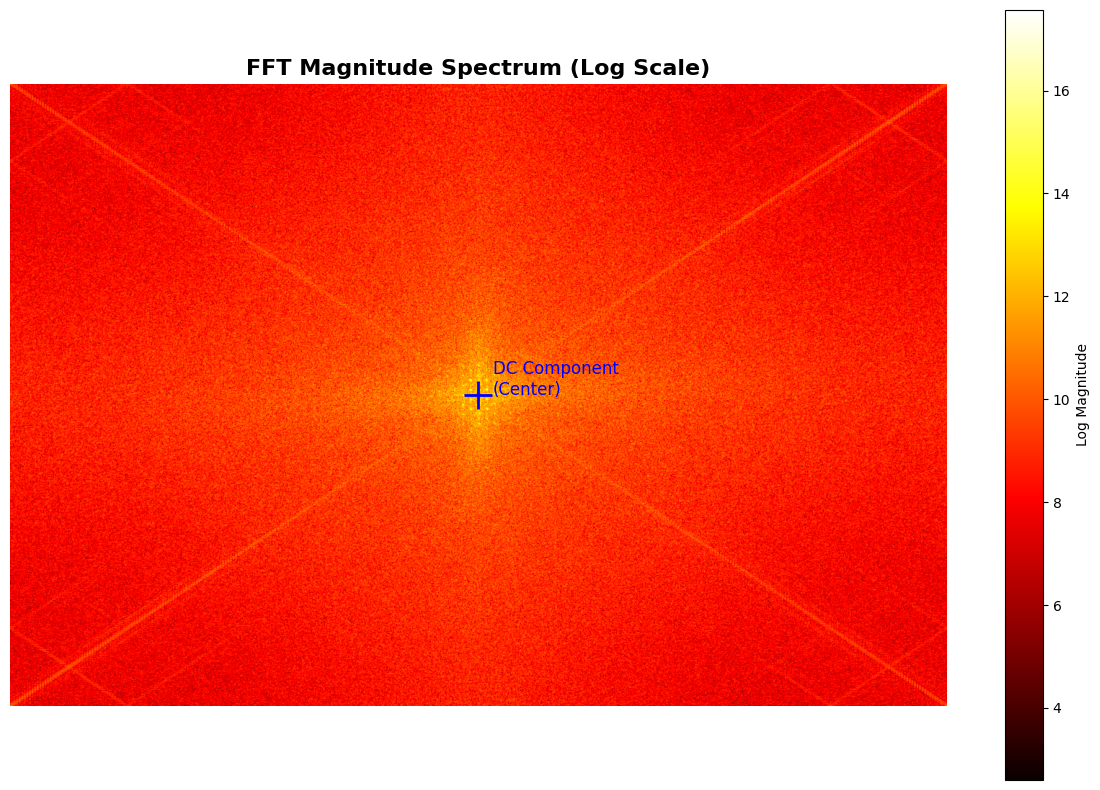


💡 What you're seeing:
   - Bright center = DC component (average brightness)
   - Bright spots away from center = periodic patterns (threads!)
   - Distance from center = frequency (1/spacing)


In [42]:
print("Computing 2D FFT...")

# Compute FFT
f_transform = np.fft.fft2(gray_windowed)
f_shift = np.fft.fftshift(f_transform)
magnitude_spectrum = np.abs(f_shift)

# Log scale for visualization
magnitude_log = np.log1p(magnitude_spectrum)

print("✓ FFT computation complete")

# Display FFT spectrum
plt.figure(figsize=(12, 8))
plt.imshow(magnitude_log, cmap='hot')
plt.title('FFT Magnitude Spectrum (Log Scale)', fontsize=16, fontweight='bold')
plt.colorbar(label='Log Magnitude')
plt.axis('off')

# Mark center
cy, cx = height // 2, width // 2
plt.plot(cx, cy, 'b+', markersize=20, markeredgewidth=2)
plt.text(cx + 20, cy, 'DC Component\n(Center)', color='blue', fontsize=12)

plt.tight_layout()
plt.show()

print("\n💡 What you're seeing:")
print("   - Bright center = DC component (average brightness)")
print("   - Bright spots away from center = periodic patterns (threads!)")
print("   - Distance from center = frequency (1/spacing)")

## 5. Analyze Frequency Peaks

We extract 1D slices through the center and find peaks:
- **Horizontal slice** → Vertical thread spacing
- **Vertical slice** → Horizontal thread spacing

✓ Found 1 peaks in vertical spectrum (horizontal threads)
✓ Found 1 peaks in horizontal spectrum (vertical threads)


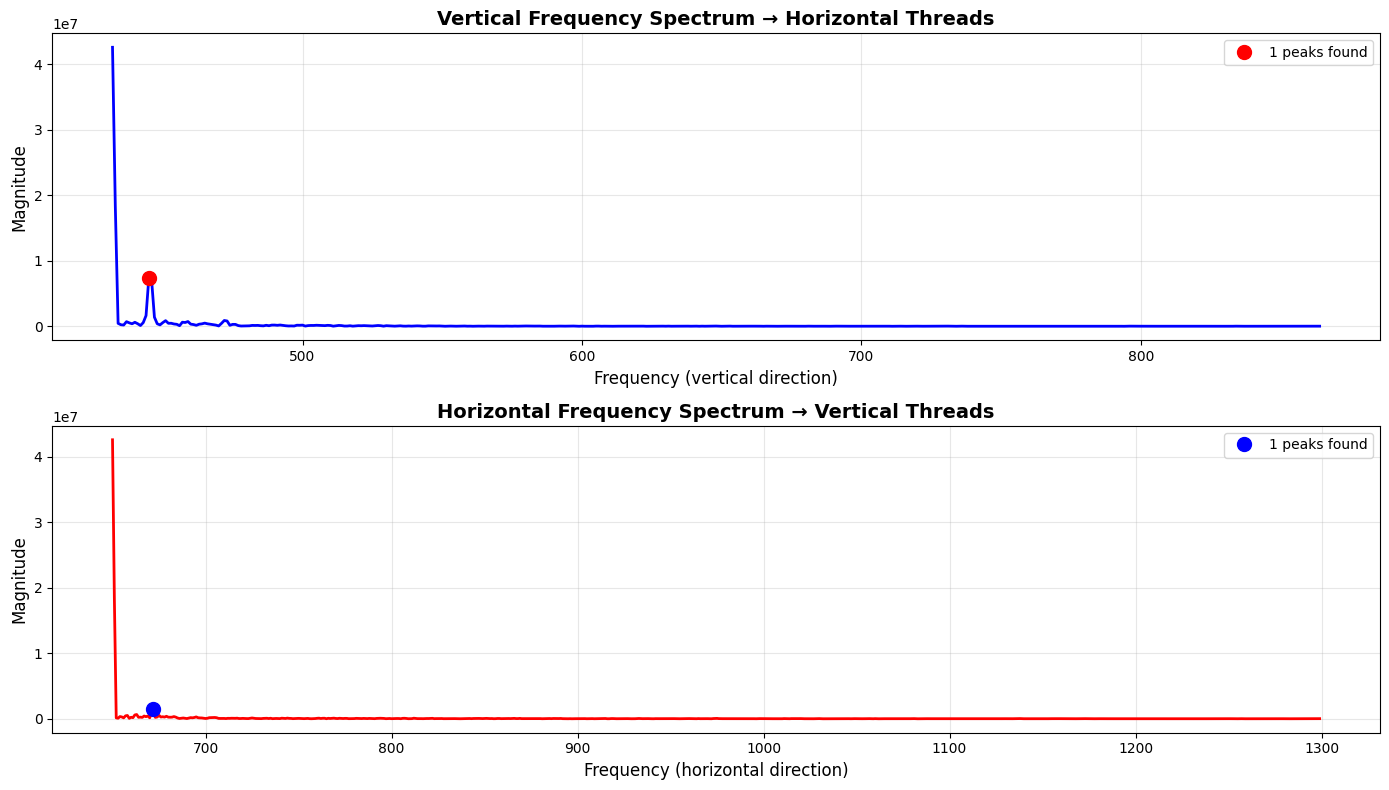

In [43]:
# Get center coordinates
cy, cx = height // 2, width // 2

# Extract 1D slices through center
horizontal_spectrum = magnitude_spectrum[cy, :]  # Horizontal slice
vertical_spectrum = magnitude_spectrum[:, cx]    # Vertical slice

# Find peaks in vertical spectrum (= horizontal threads)
v_peaks, v_properties = signal.find_peaks(
    vertical_spectrum[cy:],  # Only positive frequencies
    distance=5,
    prominence=np.std(vertical_spectrum) * 0.5
)

# Find peaks in horizontal spectrum (= vertical threads)
h_peaks, h_properties = signal.find_peaks(
    horizontal_spectrum[cx:],  # Only positive frequencies
    distance=5,
    prominence=np.std(horizontal_spectrum) * 0.5
)

print(f"✓ Found {len(v_peaks)} peaks in vertical spectrum (horizontal threads)")
print(f"✓ Found {len(h_peaks)} peaks in horizontal spectrum (vertical threads)")

# Visualize the spectrums with peaks
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Vertical spectrum (horizontal threads)
freq_range_v = np.arange(cy, len(vertical_spectrum))
axes[0].plot(freq_range_v, vertical_spectrum[cy:], 'b-', linewidth=2)
if len(v_peaks) > 0:
    axes[0].plot(cy + v_peaks, vertical_spectrum[cy + v_peaks], 'ro', 
                markersize=10, label=f'{len(v_peaks)} peaks found')
axes[0].set_xlabel('Frequency (vertical direction)', fontsize=12)
axes[0].set_ylabel('Magnitude', fontsize=12)
axes[0].set_title('Vertical Frequency Spectrum → Horizontal Threads', 
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Horizontal spectrum (vertical threads)
freq_range_h = np.arange(cx, len(horizontal_spectrum))
axes[1].plot(freq_range_h, horizontal_spectrum[cx:], 'r-', linewidth=2)
if len(h_peaks) > 0:
    axes[1].plot(cx + h_peaks, horizontal_spectrum[cx + h_peaks], 'bo', 
                markersize=10, label=f'{len(h_peaks)} peaks found')
axes[1].set_xlabel('Frequency (horizontal direction)', fontsize=12)
axes[1].set_ylabel('Magnitude', fontsize=12)
axes[1].set_title('Horizontal Frequency Spectrum → Vertical Threads', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Calculate Thread Spacing and Count

Convert frequency peaks to spatial measurements:
- **Frequency** = peak position
- **Spacing** = image_size / frequency
- **Thread count** = image_size / spacing

In [44]:
def freq_to_spacing(peak_index, dimension):
    """Convert frequency domain peak to spatial domain spacing"""
    if peak_index == 0:
        return float('inf')
    return dimension / peak_index

# Calculate spacings for horizontal threads
horizontal_spacings = []
for peak in v_peaks:
    spacing = freq_to_spacing(peak, height)
    if 10 < spacing < height / 2:  # Filter unreasonable spacings
        horizontal_spacings.append(spacing)

# Calculate spacings for vertical threads
vertical_spacings = []
for peak in h_peaks:
    spacing = freq_to_spacing(peak, width)
    if 10 < spacing < width / 2:
        vertical_spacings.append(spacing)

# Calculate averages and counts
if horizontal_spacings:
    avg_h_spacing = np.mean(horizontal_spacings)
    h_thread_count = int(height / avg_h_spacing)
else:
    avg_h_spacing = 0
    h_thread_count = 0

if vertical_spacings:
    avg_v_spacing = np.mean(vertical_spacings)
    v_thread_count = int(width / avg_v_spacing)
else:
    avg_v_spacing = 0
    v_thread_count = 0

# Print results
print("="*60)
print("🎯 THREAD DETECTION RESULTS")
print("="*60)
print(f"\nImage: {image_path}")
print(f"Size: {width} × {height} pixels")
print(f"\n📏 HORIZONTAL THREADS (running left-right):")
print(f"   Count: {h_thread_count} threads")
print(f"   Spacing: {avg_h_spacing:.1f} pixels")
if avg_h_spacing > 0:
    print(f"   Density: {height/avg_h_spacing:.1f} threads/image-height")

print(f"\n📐 VERTICAL THREADS (running top-bottom):")
print(f"   Count: {v_thread_count} threads")
print(f"   Spacing: {avg_v_spacing:.1f} pixels")
if avg_v_spacing > 0:
    print(f"   Density: {width/avg_v_spacing:.1f} threads/image-width")

print(f"\n🎨 GRID:")
print(f"   {h_thread_count} × {v_thread_count} threads")
print("="*60)

🎯 THREAD DETECTION RESULTS

Image: plain_weave_1.jpg
Size: 1300 × 865 pixels

📏 HORIZONTAL THREADS (running left-right):
   Count: 13 threads
   Spacing: 66.5 pixels
   Density: 13.0 threads/image-height

📐 VERTICAL THREADS (running top-bottom):
   Count: 22 threads
   Spacing: 59.1 pixels
   Density: 22.0 threads/image-width

🎨 GRID:
   13 × 22 threads


## 7. Visualize Thread Grid

Draw the detected thread grid on top of the original image!

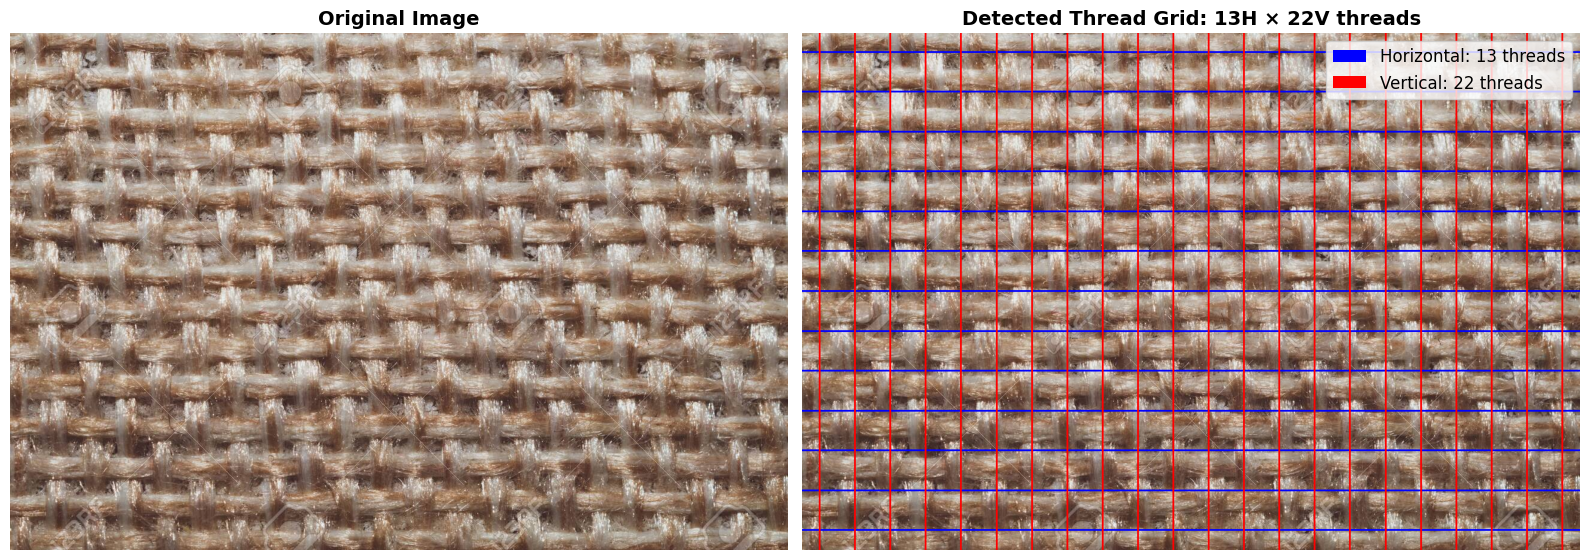

✓ Thread grid visualization complete!


In [45]:
# Create grid image
grid_img = img.copy()

# Draw horizontal threads (blue lines)
if avg_h_spacing > 0:
    y = avg_h_spacing / 2  # Start at half-spacing
    thread_num = 1
    while y < height:
        cv2.line(grid_img, (0, int(y)), (width, int(y)), (255, 0, 0), 2)
        y += avg_h_spacing
        thread_num += 1

# Draw vertical threads (red lines)
if avg_v_spacing > 0:
    x = avg_v_spacing / 2
    thread_num = 1
    while x < width:
        cv2.line(grid_img, (int(x), 0), (int(x), height), (0, 0, 255), 2)
        x += avg_v_spacing
        thread_num += 1

# Display
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original
axes[0].imshow(img_rgb)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# With grid
axes[1].imshow(cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Detected Thread Grid: {h_thread_count}H × {v_thread_count}V threads', 
                 fontsize=14, fontweight='bold')
axes[1].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label=f'Horizontal: {h_thread_count} threads'),
                   Patch(facecolor='red', label=f'Vertical: {v_thread_count} threads')]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Thread grid visualization complete!")

## 8. Complete Analysis Summary

All results in one comprehensive visualization!

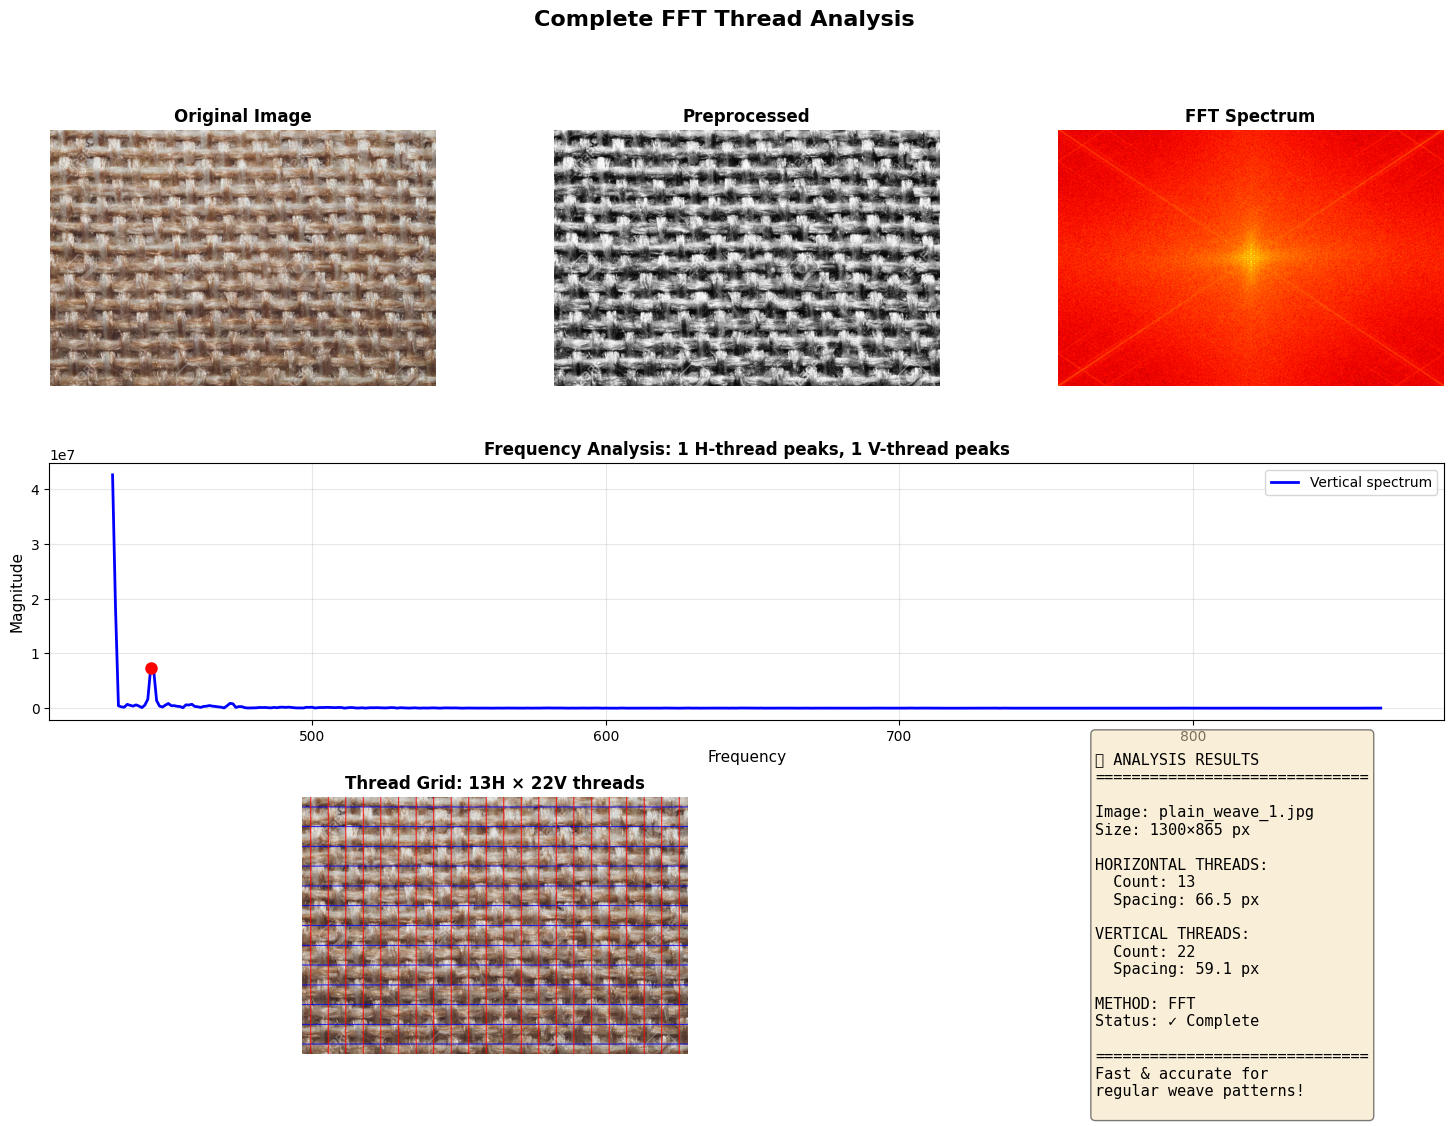


✓ Complete analysis visualization generated!


In [9]:
# Create comprehensive summary plot
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# Row 1: Processing steps
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(gray_enhanced, cmap='gray')
ax2.set_title('Preprocessed', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(magnitude_log, cmap='hot')
ax3.set_title('FFT Spectrum', fontsize=12, fontweight='bold')
ax3.axis('off')

# Row 2: Frequency analysis
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(freq_range_v, vertical_spectrum[cy:], 'b-', linewidth=2, label='Vertical spectrum')
if len(v_peaks) > 0:
    ax4.plot(cy + v_peaks, vertical_spectrum[cy + v_peaks], 'ro', markersize=8)
ax4.set_xlabel('Frequency', fontsize=11)
ax4.set_ylabel('Magnitude', fontsize=11)
ax4.set_title(f'Frequency Analysis: {len(v_peaks)} H-thread peaks, {len(h_peaks)} V-thread peaks', 
             fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Row 3: Results
ax5 = fig.add_subplot(gs[2, :2])
ax5.imshow(cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB))
ax5.set_title(f'Thread Grid: {h_thread_count}H × {v_thread_count}V threads', 
             fontsize=12, fontweight='bold')
ax5.axis('off')

# Info panel
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
info_text = f"""
📊 ANALYSIS RESULTS
{'='*30}

Image: {image_path}
Size: {width}×{height} px

HORIZONTAL THREADS:
  Count: {h_thread_count}
  Spacing: {avg_h_spacing:.1f} px

VERTICAL THREADS:
  Count: {v_thread_count}
  Spacing: {avg_v_spacing:.1f} px

METHOD: FFT
Status: ✓ Complete

{'='*30}
Fast & accurate for
regular weave patterns!
"""
ax6.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Complete FFT Thread Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n✓ Complete analysis visualization generated!")

## 9. Save Results

Save the grid image and export results to CSV

In [10]:
# Save grid image
output_filename = image_path.replace('.jpg', '_grid.png').replace('.png', '_grid.png')
cv2.imwrite(output_filename, grid_img)
print(f"✓ Saved grid image to: {output_filename}")

# Save results to text file
results_filename = image_path.replace('.jpg', '_results.txt').replace('.png', '_results.txt')
with open(results_filename, 'w') as f:
    f.write(f"Thread Detection Results\n")
    f.write(f"="*50 + "\n\n")
    f.write(f"Image: {image_path}\n")
    f.write(f"Size: {width} × {height} pixels\n\n")
    f.write(f"Horizontal Threads:\n")
    f.write(f"  Count: {h_thread_count}\n")
    f.write(f"  Spacing: {avg_h_spacing:.1f} pixels\n\n")
    f.write(f"Vertical Threads:\n")
    f.write(f"  Count: {v_thread_count}\n")
    f.write(f"  Spacing: {avg_v_spacing:.1f} pixels\n\n")
    f.write(f"Grid: {h_thread_count} × {v_thread_count} threads\n")
    f.write(f"Method: FFT (Fourier Transform)\n")

print(f"✓ Saved results to: {results_filename}")
print("\n✓ All results saved successfully!")

✓ Saved grid image to: plain_weave_1_grid_grid.png
✓ Saved results to: plain_weave_1_results.txt

✓ All results saved successfully!


## 10. Batch Processing (Optional)

Want to analyze multiple images? Run this cell!

In [ ]:
# List of images to process
image_list = [
    "plain_weave_1.jpg",
    "plain_weave_2.jpg",
    "denim_1.jpg"
    # Add more images here...
]

print("Starting batch processing...\n")

batch_results = []

for img_path in image_list:
    try:
        # Load and process (simplified version)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️  Skipping {img_path} - file not found")
            continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        
        # Quick FFT analysis (reusing code from above)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_enh = clahe.apply(gray)
        window = np.outer(np.hamming(h), np.hamming(w))
        gray_win = gray_enh * window
        
        f_transform = np.fft.fft2(gray_win)
        f_shift = np.fft.fftshift(f_transform)
        mag_spec = np.abs(f_shift)
        
        cy, cx = h // 2, w // 2
        v_spec = mag_spec[:, cx]
        h_spec = mag_spec[cy, :]
        
        v_pks, _ = signal.find_peaks(v_spec[cy:], distance=5, prominence=np.std(v_spec)*0.5)
        h_pks, _ = signal.find_peaks(h_spec[cx:], distance=5, prominence=np.std(h_spec)*0.5)
        
        # Calculate results
        h_spaces = [h/p for p in v_pks if 10 < h/p < h/2]
        v_spaces = [w/p for p in h_pks if 10 < w/p < w/2]
        
        h_space = np.mean(h_spaces) if h_spaces else 0
        v_space = np.mean(v_spaces) if v_spaces else 0
        
        h_count = int(h / h_space) if h_space > 0 else 0
        v_count = int(w / v_space) if v_space > 0 else 0
        
        batch_results.append({
            'filename': img_path,
            'h_threads': h_count,
            'v_threads': v_count,
            'h_spacing': h_space,
            'v_spacing': v_space
        })
        
        print(f"✓ {img_path}: {h_count}H × {v_count}V threads")
        
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")

# Display summary
if batch_results:
    print("\n" + "="*60)
    print("BATCH PROCESSING SUMMARY")
    print("="*60)
    
    import pandas as pd
    df = pd.DataFrame(batch_results)
    print(df.to_string(index=False))
    
    # Save to CSV
    df.to_csv('batch_results.csv', index=False)
    print("\n✓ Results saved to: batch_results.csv")
else:
    print("\n⚠️  No images were processed successfully")

---

## 🎉 Congratulations!

You've successfully analyzed fabric threads using FFT!

### Next Steps:

1. **Try different images** - Change `image_path` in Cell 2
2. **Experiment with parameters** - Adjust `prominence` in Cell 5
3. **Batch process** - Use Cell 10 for multiple images
4. **Compare methods** - Try spatial detection for irregular patterns

### Tips:

- FFT works best for **regular weave patterns**
- If detection fails, try **adjusting contrast** (CLAHE clipLimit)
- For **irregular patterns**, use spatial detection methods
- Save your notebook: File → Download as → Notebook (.ipynb)

---

**Questions?** Check the documentation:
- `FFT_VS_SPATIAL_COMPARISON.md`
- `IMPROVEMENT_GUIDE.md`
- `JUPYTER_SETUP_GUIDE.md`